In [1]:
import pandas as pd
import re
import gensim 
import mglearn
import numpy as np
import os
import matplotlib.pyplot as plta
from konlpy.utils import pprint
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Kkma, Twitter
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from gensim.models.word2vec import Word2Vec
from gensim import corpora

import time
import datetime

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
# from konlpy.corpus import kolaw
# from konlpy.tag import Twitter; t = Twitter()
# from konlpy.tag import Okt; t = Okt()
#!pip install customized_konlpy
from ckonlpy.tag import Twitter; t = Twitter()
import ckonlpy

from konlpy.tag import Hannanum; h = Hannanum()
from konlpy.tag import Kkma; k = Kkma()
from konlpy.tag import Komoran; ko = Komoran()
# 윈도우 버전에서는 지원하지 않음
from konlpy.tag import Mecab; m = Mecab()

from collections import Counter

import pickle

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [3]:
# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
from matplotlib import style

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# fname 옵션을 사용하는 방법
fontPath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=fontPath, size=18)

font_name = font_manager.FontProperties(fname=fontPath).get_name()
rc('font', family=font_name)
# style.use('ggplot')

from wordcloud import WordCloud

In [26]:
yearKSEIA = range(2013, 2019)

def fileRead(files):
    textCorpus = []
    
    for file in files:
        print(file, '파일을 처리합니다.')
        corpus = open(file).read()
        tokens = morpheme_t(removeStopwords_init(corpus))
        print('                 불용어를 처리하고 있습니다.')
        tokens = removeStopwords(tokens)
            
        if len(tokens) != 0: 
            textCorpus.append(tokens)
    
    return textCorpus

def removeStopwords_init(contexts):
    stop_words=['의 경우','될 경우','한 경우','인 경우','을 경우','는 경우','나타','에 대한',]
    
    for each_word in stop_words: contexts = contexts.replace(each_word, '')
    
    return contexts

def morpheme_t(contexts):
    t_nouns = t.nouns(contexts)
    t_tokens = [n for n in t_nouns if len(n) > 1]
    
    return t_tokens

def removeStopwords(tokens):
    stop_words = ['대한','최대한']
    
    t_tokens = [each_word for each_word in tokens if each_word not in stop_words]
    print(len(tokens), "->", len(t_tokens))
    
    return t_tokens

userDics = ['한국환경정책평가연구원','한국환경정책.평가연구원','한국환경정책·평가연구원', #기관명
            '환경정책','의무제','관리제','물관리','녹색성장',
            '민간환경감시단',
            '비점오염원','생물자원','강추위','혹한','혹서','이상저온',
            '이상고온','열섬','열파','이상기온',
            '집중강우','풍수해','황사비',
            '배출허용기준','해양배출업','배출량','배출업소','배출권','배출가스','오염취약지역','취약지역',
            '분리배출'
           ,'감축정책','감축대책', #온실가스
            '경우',
            '환경영향평가','영향평가','환경평가','전략환경평가',
            '춘계학술대회','추계학술대회','학술대회',
            '이용방법','이용계획','분석결과',
            '조사지역',
            '자원순환','대기질','비탈면','토사적치','귀화식물','식생피복',
            '한국환경영향평가학회','대한토목학회','강릉원주대학교',
            '환경연구소','세민환경연구소','생물연구교육센터','환경대학원','환경계획연구소',
           ]

for userWord in userDics: t.add_dictionary(userWord,'Noun')

In [27]:
txtList = []
pathKSEIA = './02_변환(PDF＞TXT)/'
yearPathKSEIA = os.listdir(pathKSEIA)
yearPathKSEIA.sort()

for file in yearPathKSEIA: txtList.append(pathKSEIA+file)
            
txtList.sort()
txtList

['./02_변환(PDF＞TXT)/2013_1.txt',
 './02_변환(PDF＞TXT)/2013_2.txt',
 './02_변환(PDF＞TXT)/2014_1.txt',
 './02_변환(PDF＞TXT)/2014_2.txt',
 './02_변환(PDF＞TXT)/2015_1.txt',
 './02_변환(PDF＞TXT)/2015_2.txt',
 './02_변환(PDF＞TXT)/2016_1.txt',
 './02_변환(PDF＞TXT)/2016_2.txt',
 './02_변환(PDF＞TXT)/2017_1.txt',
 './02_변환(PDF＞TXT)/2017_2.txt',
 './02_변환(PDF＞TXT)/2018_1.txt']

In [28]:
textsKSEIA = []
startYear = ''

for file in txtList:
    currentYear=file.split('/')[-1][:4]
    if startYear != currentYear:
        startYear = currentYear
        print(startYear,'년을 시작합니다.')
        intPaperCountPerYear = 1

    if intPaperCountPerYear == 1:
        textsKSEIA.append(removeStopwords_init(open(file).read()))
    else:
        textsKSEIA[-1]+=removeStopwords_init(open(file).read())
    print(currentYear,'년도',str(intPaperCountPerYear).zfill(2),'번째 처리하였습니다.')    
    intPaperCountPerYear += 1

2013 년을 시작합니다.
2013 년도 01 번째 처리하였습니다.
2013 년도 02 번째 처리하였습니다.
2014 년을 시작합니다.
2014 년도 01 번째 처리하였습니다.
2014 년도 02 번째 처리하였습니다.
2015 년을 시작합니다.
2015 년도 01 번째 처리하였습니다.
2015 년도 02 번째 처리하였습니다.
2016 년을 시작합니다.
2016 년도 01 번째 처리하였습니다.
2016 년도 02 번째 처리하였습니다.
2017 년을 시작합니다.
2017 년도 01 번째 처리하였습니다.
2017 년도 02 번째 처리하였습니다.
2018 년을 시작합니다.
2018 년도 01 번째 처리하였습니다.


In [29]:
print(len(textsKSEIA),len(textsKSEIA[0]))

6 348722


In [30]:
textsKSEIA_All = ''
for text in textsKSEIA:
    print(len(text))
    textsKSEIA_All+=text

print(len(textsKSEIA_All))

348722
779912
438606
558661
525283
211276
2862460


In [31]:
tokensKSEIA = []
intYear = 0
for text in textsKSEIA:
    print(yearKSEIA[intYear],'년 진행하겠습니다.')
    tokensKSEIA.append(morpheme_t(text))
    intYear+=1
print(len(tokensKSEIA),len(tokensKSEIA[0]))

2013 년 진행하겠습니다.
2014 년 진행하겠습니다.
2015 년 진행하겠습니다.
2016 년 진행하겠습니다.
2017 년 진행하겠습니다.
2018 년 진행하겠습니다.
6 55193


In [32]:
for year in yearKSEIA:
    print(year)

2013
2014
2015
2016
2017
2018


In [33]:
countsKSEIA = []

for tokens in tokensKSEIA:
    countsKSEIA.append(Counter(tokens).most_common())
    
countsKSEIA[0][:50]

[('연구', 813),
 ('환경', 620),
 ('평가', 549),
 ('분석', 453),
 ('결과', 445),
 ('영향', 405),
 ('관리', 382),
 ('개발', 366),
 ('조사', 353),
 ('지역', 342),
 ('이용', 317),
 ('방법', 290),
 ('사업', 287),
 ('적용', 283),
 ('수질', 278),
 ('환경영향평가', 272),
 ('계획', 272),
 ('자료', 258),
 ('방안', 249),
 ('대상', 235),
 ('생태', 219),
 ('위해', 217),
 ('발생', 214),
 ('변화', 207),
 ('하천', 203),
 ('기준', 198),
 ('시스템', 197),
 ('기후변화', 189),
 ('한국', 187),
 ('예측', 183),
 ('시설', 181),
 ('한국환경영향평가학회', 172),
 ('특성', 168),
 ('공원', 163),
 ('오염', 163),
 ('지점', 162),
 ('산림', 162),
 ('가능', 161),
 ('생태계', 159),
 ('고찰', 159),
 ('토지', 151),
 ('제도', 150),
 ('해양', 149),
 ('서식', 149),
 ('제시', 147),
 ('도시', 144),
 ('고려', 139),
 ('증가', 138),
 ('습지', 136),
 ('분포', 131)]

6


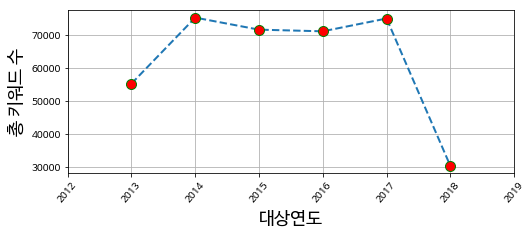

In [92]:
    values = []
    for token in tokensKSEIA: values.append(len(token))
    
    print(len(values))
    plt.plot(yearKSEIA, values, label='키워드 수', lw=2, ls="--", marker="o", ms=10, mew=1, mfc="r", mec="g")
    plt.xticks(rotation = 50)
    plt.rcParams['figure.figsize'] = (8,3)
    plt.xlim(2012, 2019)
    plt.ylabel('총 키워드 수', fontproperties=fontprop)
    plt.xlabel('대상연도', fontproperties=fontprop)
    plt.grid(True)

    plt.savefig('./05_키워드트렌드/KSEIA_연도별_키워드수 변화_' + str(datetime.datetime.now().strftime('%Y%m%d_%H%M_')) + '_트렌드.png', dpi=200)

In [34]:
countsKSEIAperYear = []
listTop50KSEIA = pd.DataFrame()
intCountYear = 0

# 키워드 순위
intKeywordsRanking=50

for counts in countsKSEIA:
    if len(listTop50KSEIA)==0:
        listTop50KSEIA=pd.DataFrame(counts[:intKeywordsRanking],columns=[str(yearKSEIA[intCountYear])+'년',
                                                                         '키워드수'])
    else:
        listTop50KSEIA=pd.concat([listTop50KSEIA,pd.DataFrame(counts[:intKeywordsRanking],columns=[str(yearKSEIA[intCountYear])+'년',
                                                                                                   '키워드수'])],axis=1)
    intCountYear+=1
        
listTop50KSEIA

,2013년,키워드수,2014년,키워드수,2015년,키워드수,2016년,키워드수,2017년,키워드수,2018년,키워드수
0,연구,813,연구,1068,연구,987,연구,1170,연구,1268,환경,472
1,환경,620,분석,762,환경,778,분석,851,환경,1032,연구,451
2,평가,549,환경,731,분석,750,환경,767,분석,880,분석,338
3,분석,453,지역,711,결과,618,평가,697,평가,877,결과,277
4,결과,445,평가,708,지역,589,결과,593,지역,730,지역,260
5,영향,405,영향,689,사업,576,지역,589,결과,694,계획,257
6,관리,382,결과,662,평가,565,관리,544,사업,656,평가,251
7,개발,366,사업,518,영향,565,영향,478,영향,631,영향,241
8,조사,353,개발,435,조사,496,이용,453,개발,574,생태,236
9,지역,342,조사,415,개발,471,조사,451,조사,503,사업,216


In [134]:
# 키워드 순위 0:20, 20:40, 40:60
intKeywordsRankingStart=60
intKeywordsRankingEnd=80

countsKSEIAperYear = []
listTop50KSEIA = pd.DataFrame()
intCountYear = 0

for counts in countsKSEIA:
    if len(listTop50KSEIA)==0:
        listTop50KSEIA=pd.DataFrame(counts[intKeywordsRankingStart:intKeywordsRankingEnd],
                                    columns=[str(yearKSEIA[intCountYear])+'년','키워드수'])
    else:
        listTop50KSEIA=pd.concat([listTop50KSEIA,pd.DataFrame(counts[intKeywordsRankingStart:intKeywordsRankingEnd],
                                                              columns=[str(yearKSEIA[intCountYear])+'년','키워드수'])]
                                 ,axis=1)
    intCountYear+=1

listTop50KSEIA.index=range(intKeywordsRankingStart+1,intKeywordsRankingEnd+1)
listTop50KSEIA

,2013년,키워드수,2014년,키워드수,2015년,키워드수,2016년,키워드수,2017년,키워드수,2018년,키워드수
61,환경과학,119,하천,170,폐기물,163,기반,165,다양,168,사례,72
62,서울대학교,119,서식,168,항목,161,구축,165,예측,165,기능,72
63,개선,119,측정,167,수행,159,수행,164,등급,164,이상,72
64,선정,117,기상,166,평균,158,배출,162,분포,164,수행,72
65,유역,117,면적,165,증가,157,시설,157,또한,164,운영,71
66,자연,117,현황,164,도로,156,비교,157,효과,163,작성,68
67,통해,117,모형,163,제도,155,가장,157,오염,162,수립,67
68,항목,117,지구,162,사례,153,사회,154,필요,161,하천,67
69,수행,115,공간,161,국내,152,유역,154,사회,160,또한,67
70,공간,114,또한,161,사용,150,토지,152,검토,160,모델,65


In [36]:
def keywordsTrend(tokens, keywords):
    plt.rcParams['figure.figsize'] = (14,4)
    labels = []

#     print(len(keywords))
    if len(keywords) == 0:
        print("알고 싶은 키워드를 입력하십시오.")
        return
    
    for keyword in keywords:
        values = []
        labels.append(keyword)
#         print(keyword, len(tokens))
        for token in tokens:
#             print(len(token))
            try:
                values.append(dict(Counter(token))[keyword])
            except:
                values.append(0)
        
#         print(len(tokens))
        plt.plot(yearKSEIA, values, label=keyword, lw=2, ls="--", marker="o", ms=7, mew=1)#, mfc="r", mec="g")
#         포인트 안에 색(mfc)
#         포인트 테두리 색(mec)
    
#     plt.rcParams['figure.figsize'] = (14,14)
#     plt.xticks(rotation=50)
    plt.rcParams['figure.figsize'] = (10,3)
    plt.legend(loc='upper left')
#     plt.title('전체 텍스트 분석결과', fontproperties=fontprop)
    plt.ylabel('총 키워드 수', fontproperties=fontprop)
    plt.xlabel('대상연도', fontproperties=fontprop)
    plt.xlim(2012,2019)

    plt.savefig('./05_키워드트렌드/KSEIA_연도별_' + str(datetime.datetime.now().strftime('%Y%m%d_%H%M_')) + 
                keyword + '_트렌드.png', dpi=200)

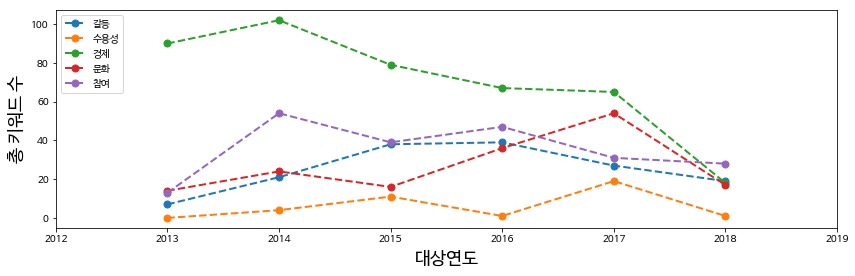

In [116]:
# keywordsTrend(tokensKSEIA,['대기','대기질','수질','토양','지형','지질','동물','식물','자원순환',
#                            '자원','순환','친환경','소음','진동'])
# 수질 제거
# keywordsTrend(tokensKSEIA,['대기','대기질','토양','지형','지질','동물','식물','자원순환','자원','순환','친환경','소음','진동'])
# 토양 제거
# keywordsTrend(tokensKSEIA,['대기','대기질','지형','지질','동물','식물','자원순환','자원','순환','친환경','소음','진동'])
# 소음 제거
# keywordsTrend(tokensKSEIA,['대기','대기질','지형','지질','동물','식물','자원순환','자원','순환','친환경','진동'])

keywordsTrend(tokensKSEIA,['갈등','수용성','경제','문화','참여'])

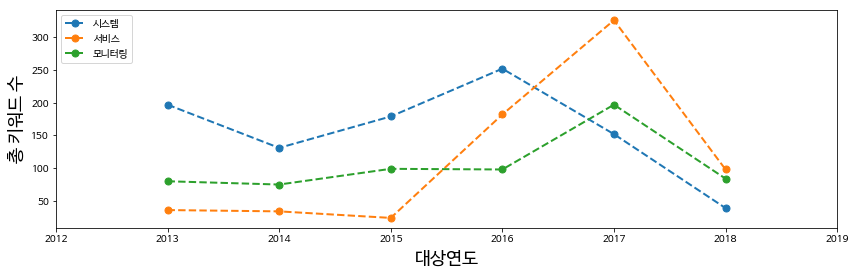

In [126]:
keywordsTrend(tokensKSEIA,['시스템','서비스','모니터링'])

In [87]:
def keywordsTrendBarStacked(tokens, keywords):
    plt.rcParams['figure.figsize'] = (14,4)
    labels = []
    bottomValues = []
    preBottomValues = []
    intCheckBottomCount = 10
    
    if len(bottomValues) == 0:
        for i in range(0, len(tokens)):
            bottomValues.append(0) 
            preBottomValues.append(0)
#     print(bottomValues)
#     preBottomValues = bottomValues

#     print(len(keywords))
    if len(keywords) == 0:
        print("알고 싶은 키워드를 입력하십시오.")
        return
    
    for keyword in keywords:
        values = []
        intValueCount = 0
        labels.append(keyword)
#         print(keyword, len(tokens))
#         print(preBottomValues)
        for token in tokens:
#             print(len(token))
            try:
                bottomValue = dict(Counter(token))[keyword]
#                 if intCheckBottomCount != 0:
#                     print(bottomValue)
#                     : values[intValueCount] = bottomValue
                values.append(bottomValue)
                preBottomValues[intValueCount] = bottomValues[intValueCount]
                bottomValues[intValueCount] +=  bottomValue
            except:
                values.append(0)
            
            intValueCount += 1
#         print(len(tokens))
#         plt.plot(yearEnvWhitep, values, label=keyword, lw=2, ls="--", marker="o", ms=7, mew=1)#, mfc="r", mec="g")
        
#         print(preBottomValues)
        if intCheckBottomCount == 0:
            plt.bar(yearKSEIA, values, bottom=None, label=keyword)
        else:
            plt.bar(yearKSEIA, values, bottom=preBottomValues, label=keyword)

#         포인트 안에 색(mfc)
#         포인트 테두리 색(mec)
#         preBottomValues = bottomValues

        intCheckBottomCount += 1
    
#     plt.rcParams['figure.figsize'] = (14,14)
    plt.xticks(rotation=50)
    plt.rcParams['figure.figsize'] = (12,3)
    plt.legend(loc='upper left', )
#     plt.title('기후변화 텍스트 분석결과', fontproperties=fontprop)
    plt.ylabel('총 키워드 수', fontproperties=fontprop)
    plt.xlabel('대상연도', fontproperties=fontprop)
#     plt.ylim(0,10000)
#     plt.yscale

    plt.xlim(2012,2019)

    plt.savefig('./05_키워드트렌드/KSEIA_연도별(바스택)_' + str(datetime.datetime.now().strftime('%Y%m%d_%H%M_')) + 
                keyword + '_트렌드.png', dpi=200)

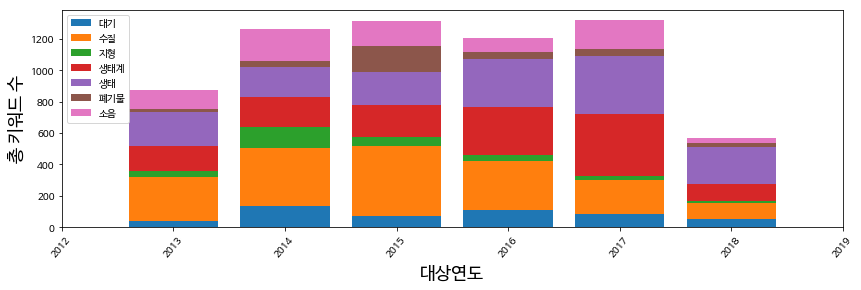

In [88]:
keywordsTrendBarStacked(tokensKSEIA,['대기','수질','지형','생태계','생태','폐기물','소음'])

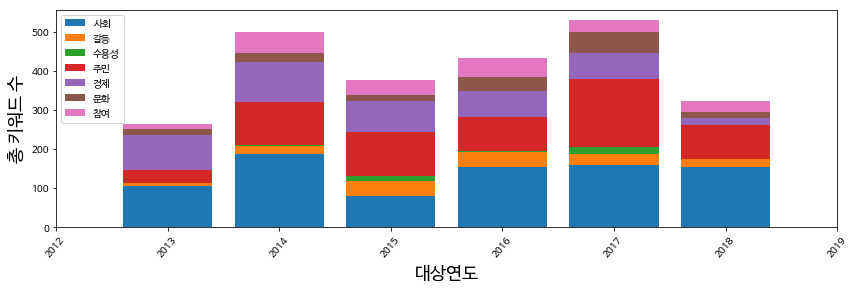

In [122]:
keywordsTrendBarStacked(tokensKSEIA,['사회','갈등','수용성','주민','경제','문화','참여'])

In [96]:
def showWordcloud(maxCount,tokenSet):
    for tokens in tokenSet:
        wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                             relative_scaling = 0.2,
                             background_color = 'white',
                             ).generate_from_frequencies(dict(tokens[:maxCount]))

        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

In [98]:
intMaxCount=100
# countsKSEIAperYear[0].most_count()
showWordcloud(intMaxCount,countsKSEIAperYear)

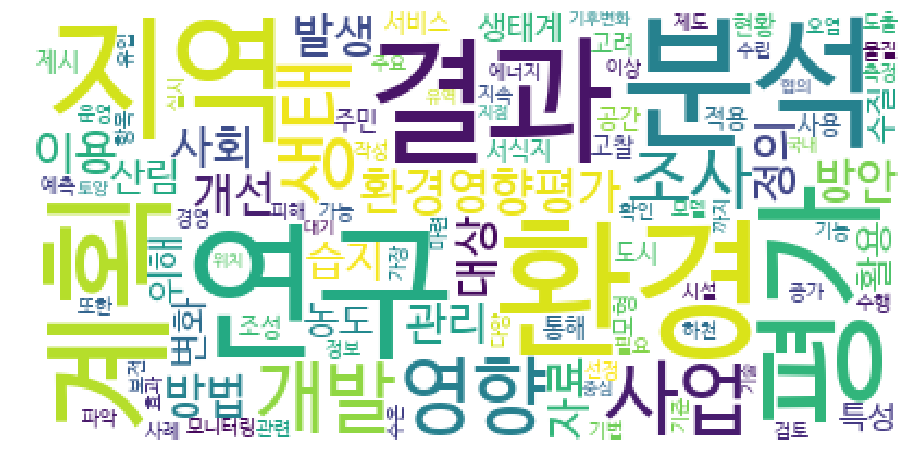

In [121]:
wordcloud=WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                    relative_scaling = 0.2,
                    background_color = 'white',).generate_from_frequencies(dict(countsKSEIA[5][:100]))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [127]:
corpusKSEIA = fileRead(txtList)

dictKSEIA = corpora.Dictionary(corpusKSEIA)
newKSEIA = [dictKSEIA.doc2bow(text) for text in corpusKSEIA]

./02_변환(PDF＞TXT)/2013_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
22986 -> 22965
./02_변환(PDF＞TXT)/2013_2.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
32207 -> 32168
./02_변환(PDF＞TXT)/2014_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
42051 -> 42022
./02_변환(PDF＞TXT)/2014_2.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
33113 -> 33091
./02_변환(PDF＞TXT)/2015_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
38382 -> 38363
./02_변환(PDF＞TXT)/2015_2.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
33135 -> 33111
./02_변환(PDF＞TXT)/2016_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
26018 -> 26006
./02_변환(PDF＞TXT)/2016_2.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
44998 -> 44981
./02_변환(PDF＞TXT)/2017_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
30129 -> 30118
./02_변환(PDF＞TXT)/2017_2.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
44763 -> 44741
./02_변환(PDF＞TXT)/2018_1.txt 파일을 처리합니다.
                 불용어를 처리하고 있습니다.
30286 -> 30276


In [129]:
for topicsNo in range(4, 21):
    ldaKSEIA = gensim.models.ldamodel.LdaModel(newKSEIA, num_topics = topicsNo, id2word=dictKSEIA, passes=15)
    lda_displayKSEIA = pyLDAvis.gensim.prepare(ldaKSEIA, newKSEIA, dictKSEIA, sort_topics=False)
    pyLDAvis.display(lda_displayKSEIA)
    pyLDAvis.save_html(lda_displayKSEIA, './10_LDA-분석결과/KSEIA_전체 텍스트_' + str(datetime.datetime.now().strftime("%Y%m%d_%H%M_")) + str(topicsNo).zfill(2) + ".html")

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))
